In [1]:
import torch
from torch import nn

## Dataset

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

In [15]:
t="""class PedDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        self.names = [fname.split('.')[0] for fname in os.listdir(os.path.join(self.root, 'Annotation'))]

    def __getitem__(self, idx):
        name = self.names[idx]
        imgpath = os.path.join(self.root, 'PNGImages', name+'.png')
        img = np.array(Image.open(imgpath))

        maskpath = os.path.join(self.root, 'PedMasks', name+'_mask.png')
        mask = np.array(Image.open(maskpath))

        mask_indices = np.unique(mask)[1:]
        masklist = (mask[None, :, :] == mask_indices[:, None, None]) # num_instances H W
        
        boxlist = []
        for i in range(len(masklist)):
            mask = masklist[i]
            y, x = np.nonzero(mask)
            xx = np.min(x)
            yx = np.max(x)
            xy = np.min(y)
            yy = np.max(y)
            
            boxlist.append((xx, xy, yx, yy))

        clslist = []
        for mask in masklist:
            clslist.append(1)

        return img, clslist, boxlist, masklist
    
    def __len__(self):
        return len(self.names)

pd = PedDataset('PennFudanPed')""".replace("    ", "  ")
print(t)

class PedDataset(torch.utils.data.Dataset):
  def __init__(self, root):
    self.root = root
    self.names = [fname.split('.')[0] for fname in os.listdir(os.path.join(self.root, 'Annotation'))]

  def __getitem__(self, idx):
    name = self.names[idx]
    imgpath = os.path.join(self.root, 'PNGImages', name+'.png')
    img = np.array(Image.open(imgpath))

    maskpath = os.path.join(self.root, 'PedMasks', name+'_mask.png')
    mask = np.array(Image.open(maskpath))

    mask_indices = np.unique(mask)[1:]
    masklist = (mask[None, :, :] == mask_indices[:, None, None]) # num_instances H W
    
    boxlist = []
    for i in range(len(masklist)):
      mask = masklist[i]
      y, x = np.nonzero(mask)
      xx = np.min(x)
      yx = np.max(x)
      xy = np.min(y)
      yy = np.max(y)
      
      boxlist.append((xx, xy, yx, yy))

    clslist = []
    for mask in masklist:
      clslist.append(1)

    return img, clslist, boxlist, masklist
  
  def __len__(self):
    return len(self.names)



In [17]:
class PedDataset(torch.utils.data.Dataset):
  def __init__(self, root):
    self.root = root
    self.names = [fname.split('.')[0] for fname in os.listdir(os.path.join(self.root, 'Annotation'))]

  def __getitem__(self, idx):
    name = self.names[idx]
    imgpath = os.path.join(self.root, 'PNGImages', name+'.png')
    img = np.array(Image.open(imgpath))

    maskpath = os.path.join(self.root, 'PedMasks', name+'_mask.png')
    mask = np.array(Image.open(maskpath))

    mask_indices = np.unique(mask)[1:]
    masklist = (mask[None, :, :] == mask_indices[:, None, None]) # num_instances H W
    
    boxlist = []
    for i in range(len(masklist)):
      mask = masklist[i]
      y, x = np.nonzero(mask)
      xx = np.min(x)
      yx = np.max(x)
      xy = np.min(y)
      yy = np.max(y)
      
      boxlist.append((xx, xy, yx, yy))

    clslist = []
    for mask in masklist:
      clslist.append(1)

    return img, clslist, boxlist, masklist
  
  def __len__(self):
    return len(self.names)

pd = PedDataset('PennFudanPed')

In [241]:
import torchvision
import torch.nn.functional as F

@torch.no_grad()
def collate_fn(batch):
  imgs, clslist, boxlist, masklist = tuple(zip(*batch))
  N = len(batch)
  K = sum([len(G) for G in clslist])

  # to tensor
  imgs = [torchvision.transforms.functional.to_tensor(img) for img in imgs]
  GT_cls = [torch.tensor(l) for l in clslist]
  GT_box = [torch.tensor(lt) for lt in boxlist]
  GT_mask = [torch.tensor(lt, dtype=torch.float32) for lt in masklist]
    
  # img batching
  for i, img in enumerate(imgs):
    C, H, W = img.shape
    sH =  int(H * 400/min(H, W))
    sW =  int(W * 400/min(H, W))
    scale = 400/min(H, W)
    
    img = torchvision.transforms.functional.resize(
        img, size=(sH, sW))
    imgs[i] = img
    GT_box[i] = (GT_box[i] * scale).int()
    GT_mask[i] = F.interpolate(GT_mask[i][None, :, :, :], size=(sH, sW), mode='nearest')[0]

  maxh = max([img.shape[1] for img in imgs])
  maxw = max([img.shape[2] for img in imgs])
  maxh = int(np.ceil(maxh/32) * 32)
  maxw = int(np.ceil(maxw/32) * 32)
  X = torch.zeros(N, C, maxh, maxw)
  for i, img in enumerate(imgs):
    c, h, w = img.shape
    X[i, :c, :h, :w] = img[:, :, :]

  GT_mask_resized = []
  ###resize masking
  batch_indices = torch.tensor([i for i, l in enumerate(clslist) for _ in range(len(l))])

  for i, masks in enumerate(GT_mask):
    GT_mask = torch.zeros(len(masks), 14, 14)
    gt_box = GT_box[i]
    
    for j, mask in enumerate(masks):    
      boxed_mask = mask[gt_box[j, 1]:gt_box[j, 3]+1, gt_box[j, 0]:gt_box[j, 2]+1]
      resized_mask = F.interpolate(boxed_mask[None, None, :, :], size=(14, 14), mode='nearest')[0][0]
      GT_mask[j] = resized_mask
    GT_mask_resized.append(GT_mask)
    
  batch_indices = torch.tensor([i for i, l in enumerate(clslist) for _ in range(len(l))])

  return (X, GT_cls, GT_box, GT_mask_resized, batch_indices)

dl = torch.utils.data.DataLoader(
    pd,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [242]:
class Conv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=-1, act=True):
    super().__init__()
    padding = kernel_size // 2 if padding == -1 else padding
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(num_features=out_channels)
    self.act_layer = nn.LeakyReLU() if act == True else nn.Identity()

  def forward(self, x):
    x = self.conv2d(x)
    x = self.bn(x)
    x = self.act_layer(x)
    return x

class Bottleneck(nn.Module):
  def __init__(self, in_channels, out_channels, act=True):
    super().__init__()
    c_ = out_channels // 2
    self.conv1 = Conv(in_channels, c_, 1)
    self.conv2 = Conv(c_, out_channels, 3)
    #self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    x_ = self.conv1(x)
    x_ = self.conv2(x_)
    return x + x_

class BottleneckCSP(nn.Module):
  def __init__(self, in_channels, out_channels, n=1, act=True):
    super().__init__()
    self.conv = Conv(in_channels, out_channels, 1)
    self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    x = self.conv(x)
    x_ = x.clone()
    x = self.m(x)
    return x

class BottleneckCSP2(nn.Module):
  def __init__(self, in_channels, out_channels, n=1, act=True):
    super().__init__()
    self.conv = Conv(in_channels, out_channels, 1)
    self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    x = self.conv(x)
    x_ = x.clone()
    x = self.m(x)
    return x + x_

class Concat(nn.Module):
  def __init__(self, dim=1):
    super().__init__()
    self.dim = dim
  
  def forward(self, xs):
    x = torch.cat(xs, dim=self.dim)
    return x

class SPPCSP(nn.Module):
  def __init__(self, in_channels, out_channels, n=1, act=True):
    super().__init__()
    self.conv = Conv(in_channels, out_channels, 1)
    self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    x = self.conv(x)
    x = self.m(x)
    return x

class Detect(nn.Module):
  def __init__(self, nc, anchors=(), ch=()):
    super().__init__()
    self.nc = nc
    self.nl = len(anchors)
    self.na = len(anchors[0])//2
    self.anchors = torch.tensor(anchors).view(self.nl, self.na, 2)
    self.no = self.nc + 4 + 1
    self.convs = nn.Sequential(*[Conv(c1, self.na * (self.nc + 4 + 1), 1, act=False) for c1 in ch])

    self.strides = None
    self.grids = None

  def forward(self, xs):
    for i in range(self.nl):
      x = xs[i] # N C H W
      x = self.convs[i](x)
      N, C, H, W = x.shape
      x = x.view(N, self.na, self.no, H, W).permute(0, 1, 3, 4, 2)
      xs[i] = x
    return xs

  @staticmethod
  def _make_grid(nx=20, ny=20):
    grid_x = torch.arange(nx)
    grid_y = torch.arange(ny)
    grid_x = grid_x[None, :].repeat(ny, 1)
    grid_y = grid_y[:, None].repeat(1, nx)

    grid = torch.stack((grid_x, grid_y), dim=2)
    return grid

In [288]:
nc = 80
anchors = [(10,10, 30,30), (50,50, 70,70), (200,200, 400,400)]
backbone = [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, Bottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 9-P5/32
   [-1, 4, BottleneckCSP, [1024]],  # 10
]

head = [[-1, 1, SPPCSP, [512]], # 11
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [8, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [256]], # 16 
   [-1, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [6, 1, Conv, [128, 1, 1]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [128]], # 21
   [-1, 1, Conv, [256, 3, 1]],
   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 16], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [256]], # 25
   [-1, 1, Conv, [512, 3, 1]],
   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 11], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [512]], # 29
   [-1, 1, Conv, [1024, 3, 1]],

   [[22,26,30], 1, Detect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

In [289]:
from torch.nn import Parameter

class YOLO(nn.Module):
  def __init__(self, backbone, head):
    super().__init__()
    self.backbone = backbone
    self.head = head

    self.blocklist = nn.ModuleList()

    ch = [3]
    for i, block in enumerate(backbone + head):
      f, n, m, a = block
      if isinstance(f, int):
        f = f+1 if f >= 0 else f
      elif isinstance(f, list):
        f = [x+1 if x >= 0 else x for x in f]

      if m in [Conv, Bottleneck, BottleneckCSP, BottleneckCSP2, SPPCSP]:
        c1, c2 = ch[f], a[0]
        a = [c1, c2, *a[1:]]
        
        if m in [BottleneckCSP, BottleneckCSP2, SPPCSP]:
          a.insert(2, n)
          n = 1
      elif m == nn.Upsample:
        c2 = ch[f]
      elif m == Concat:
        c2 = sum([ch[x] for x in f])
      elif m == Detect:
        c1 = [ch[x] for x in f]
        a.insert(2, c1)
      else:
        c2 = -1

      print(m.__name__, a)
      m_ = nn.Sequential(*[m(*a) for _ in range(n)])
      m_.i, m_.f = i, f
      self.blocklist.append(m_)
      ch.append(c2)


    m = self.blocklist[-1][0] # Detect
    s = 256
    m.strides = torch.tensor([s/x.shape[2] for x in self.forward(torch.zeros(1, 3, s, s))])
    print('m.strides: ', m.strides)
    m.anchors = Parameter(m.anchors / m.strides.view(-1, 1, 1), requires_grad=False) # anchors: nl na 2

  def forward(self, x):
    y = [x]
    for i, block in enumerate(self.blocklist):
      if i == 0 or block.f == -1:
        x = block(x)
      else:
        if isinstance(block.f, int):
          x = y[block.f]
        elif isinstance(block.f, list):
          x = [y[f] for f in block.f]
        x = block(x)
      y.append(x)
      
    return x

In [290]:
yolo = YOLO(backbone, head)

Conv [3, 32, 3, 1]
Conv [32, 64, 3, 2]
Bottleneck [64, 64]
Conv [64, 128, 3, 2]
BottleneckCSP [128, 128, 2]
Conv [128, 256, 3, 2]
BottleneckCSP [256, 256, 8]
Conv [256, 512, 3, 2]
BottleneckCSP [512, 512, 8]
Conv [512, 1024, 3, 2]
BottleneckCSP [1024, 1024, 4]
SPPCSP [1024, 512, 1]
Conv [512, 256, 1, 1]
Upsample [None, 2, 'nearest']
Conv [512, 256, 1, 1]
Concat [1]
BottleneckCSP2 [512, 256, 2]
Conv [256, 128, 1, 1]
Upsample [None, 2, 'nearest']
Conv [256, 128, 1, 1]
Concat [1]
BottleneckCSP2 [256, 128, 2]
Conv [128, 256, 3, 1]
Conv [128, 256, 3, 2]
Concat [1]
BottleneckCSP2 [512, 256, 2]
Conv [256, 512, 3, 1]
Conv [256, 512, 3, 2]
Concat [1]
BottleneckCSP2 [1024, 512, 2]
Conv [512, 1024, 3, 1]
Detect [80, [(10, 10, 30, 30), (50, 50, 70, 70), (200, 200, 400, 400)], [256, 512, 1024]]
m.strides:  tensor([ 8., 16., 32.])


In [303]:
def build_targets(targets, p, model): 
  tcls, tbox, indices, anch = [], [], [], []
  det = model.blocklist[-1][0]
  na, nt = det.na, targets.shape[0]
  ai = torch.arange(na, device=targets.device)[:, None].repeat(1, nt)[:, :, None] # na, nt, 1

  thres = 3.
  for i in range(det.nl):
    anchor = det.anchors[i] #na, 2
    off = torch.tensor([[0, 0],
                         [1, 0], [0, 1], [-1, 0], [0, -1]], device=targets.device) * 0.5
    gain = torch.ones(6, device=targets.device)
    gain[2:6] *= torch.tensor(p[i].shape, device=targets.device)[[3, 2, 3, 2]]
    t = targets * gain # nt 6 * 6

    r = t[None, :, 4:6] / anchor[:, None, :]
    j = (torch.maximum(r, 1./r).max(dim=2)[0] < thres) # na, nt

    t = t.repeat(na, 1, 1)
    t = torch.cat((t, ai), dim=2) # na, nt, 7
    t = t[j]

    gxy = t[:, 2:4]
    j, k = ((gxy > 1.) & ((gxy % 1.) < 0.5)).T
    gxi = gain[:2][None, :] - gxy[:, :] # t, 2
    l, m = ((gxi > 1.) & ((gxi % 1.) < 0.5)).T
    j = torch.stack((torch.ones_like(j), j, k, l, m), dim=0)
    offset = torch.zeros_like(gxy) + off[:, None, :] # 5, nt, 2
    t = t.repeat(5, 1, 1)
    t = t[j] # s, 7
    
    b, c = t[:, :2].long().T

    gij = (t[:, 2:4] - offset[j]).long()

    x, y = gij.T
    box = t[:, 2:6]
    box[:, 0:2] -= gij
    a = t[:, 6].long()
    an = anchor[a]
    
    tcls.append(c)
    tbox.append(box)
    indices.append((b, a, y, x))
    anch.append(an)
  return tcls, tbox, indices, anch

In [304]:
def xywh_to_xxyy(box):
  x, y, w, h = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
  xxyy = torch.stack((x - w/2, y - h/2, x + w/2, y + h/2), dim=1)
  return xxyy

def xxyy_to_xywh(box):
  xx, xy, yx, yy = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
  w, h = yx - xx, yy-xy
  xywh = torch.stack((xx + w/2, xy + h/2, w, h), dim=1)
  return xywh

def GIoUxywh(abox, bbox):
  abox = xywh_to_xxyy(abox)
  bbox = xywh_to_xxyy(bbox)
  tli = torch.maximum(abox[:, :2], bbox[:, :2]) # s 2
  bri = torch.minimum(abox[:, 2:], bbox[:, 2:]) # s 2
    
  inter = ((tli < bri) * (bri - tli)).sum(dim=1)
  a = (abox[:, 2:] - abox[:, :2]).sum(dim=1)
  b = (bbox[:, 2:] - bbox[:, :2]).sum(dim=1)
  iou = inter / (a + b - inter)
    
  tlc = torch.minimum(abox[:, :2], bbox[:, :2]) # s 2
  brc = torch.maximum(abox[:, 2:], bbox[:, 2:]) # s 2
  c = (brc - tlc).sum(dim=1)
  giou = iou - (c - (a+b-inter)) / c
    
  return 1 - giou

In [305]:
nn.BCELoss()(torch.zeros(0, 2), torch.zeros(0, 2))

tensor(nan)

In [324]:
def compute_loss(p, targets, yolo):
  tcls, tbox, indices, anch = build_targets(targets, p, yolo)

  det = yolo.blocklist[-1][0]

  lcls, lbox, lobj = (torch.zeros(1, device=targets.device), 
                      torch.zeros(1, device=targets.device), 
                      torch.zeros(1, device=targets.device))

  for i in range(det.nl):
    pobj = p[i][..., 0]
    tobj = torch.zeros_like(pobj)
    
    if len(tbox[i]) > 0:
      b, a, y, x = indices[i]
      sp = p[i][b, a, y, x]

      tobj[b, a, y, x] = 1
      
      pbox = sp[:, 1:5]
      pbox[:, 0:2] = (pbox[:, 0:2]).sigmoid()*2 - 0.5
      pbox[:, 2:4] = ((pbox[:, 2:4]).sigmoid()*2)**2 * (anch[i][:, :])
      
      grid = det._make_grid(p[i].shape[3], p[i].shape[2]).to(targets.device)[y, x]
      lbox += sum(GIoUxywh(pbox, tbox[i]))

      pcls = sp[:, 5:5+80] # obj xywh cls
      lcls += nn.CrossEntropyLoss()(pcls, tcls[i])

    lobj += nn.BCEWithLogitsLoss(weight=(tobj==0)*1.+(tobj==1)*5., reduction='mean')(pobj, tobj)
  
  return lobj, lbox, lcls

In [325]:
def create_clip_optimizer_class(optimizer_type, max_norm=1):
  def optimizer_wgc_step(self, closure=None):
    for group in self.param_groups:
      for p in group["params"]:
        torch.nn.utils.clip_grad_norm_(p, max_norm=max_norm)
    return super(type(self), self).step(closure)

  OptimizerWithGradientClip = type( #types.new_class
      optimizer_type.__name__ + "WithGradClip",
      (optimizer_type,),
      {"step": optimizer_wgc_step},
  )

  #get params for optimizer

  return OptimizerWithGradientClip

In [326]:
class MultiStepParamScheduler(object):
  def __init__(self, values, milestones, num_updates):
    #[v, ...], [m, ...], int
    super().__init__()
    self.values = values
    self.milestones = milestones
    self.num_updates = num_updates

    self._milestones = milestones + [num_updates]

  def __call__(self, frac):
    iteration = frac * self.num_updates
    
    #linear search
    i = 0
    while iteration >= self._milestones[i]: # iter does not go beyond num_updates
      i += 1
    #bisect.bisect_right(_milestones, iter)
    return self.values[i]
    
class Scheduler(torch.optim.lr_scheduler._LRScheduler):
  def __init__(self, optimizer, multiplier, max_iter, last_iter=-1):
    self._multiplier = multiplier
    self._max_iter = max_iter
    super().__init__(optimizer, last_epoch=last_iter)

  def state_dict(self):
    return {"base_lrs": self.base_lrs, "last_epoch": self.last_epoch}

  def get_lr(self):
    multiplier = self._multiplier(self.last_epoch / self._max_iter)
    return [base_lr * multiplier for base_lr in self.base_lrs]

In [355]:
def train_one_epoch(dl, model, opt, sched=None, load_path=None):
  if load_path:
    model_info = torch.load(PATH)
    start_iter = model_info["iter"]
    model.load_state_dict(model_info["model_state_dict"])
  else:
    start_iter = 0

  model.train()
  for iteration, batch_inputs in zip(range(0, MAX_ITER), dl):
    X, GT_cls, GT_box, GT_mask_resized, batch_indices = batch_inputs
    
    GT_cls = torch.cat(GT_cls, dim=0)
    GT_box = torch.cat(GT_box, dim=0)
    GT_box = xxyy_to_xywh(GT_box)
    GT_box = GT_box / torch.tensor(X.shape)[[3, 2, 3, 2]] # as X is Y-X but GT is X-Y scheme
    
    targets = torch.cat((batch_indices[:, None], GT_cls[:, None], GT_box), dim=1)
    X, GT_cls, GT_box, batch_indices, targets = list(map(
        lambda x: x.to("cuda" if torch.cuda.is_available() else "cpu"), 
        [X, GT_cls, GT_box, batch_indices, targets]))
    p = model(X)
    
    lobj, lbox, lcls = compute_loss(p, targets, model)
    loss = lobj + lbox + lcls

    opt.zero_grad()
    loss.backward()
    opt.step()

    if sched:
      sched.step()

    if iteration % 10 == 0:
      print(f'iter {iteration}, loss: {loss.item()}')
      print(f'lr : {opt.param_groups[0]["lr"]}')
    
    if iteration % 100 == 0:  
      # evaluator.evaluate()
      pass

    if iteration % 100 == 0:
      model_info = {
        'iter':iteration,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':opt.state_dict(),
        'scheduler_state_dict':sched.state_dict()
      }
      PATH = f'model_{iteration}.pt'
      torch.save(model_info, PATH)

In [413]:
nc = 2
anchors = [(10,10, 30,30), (50,50, 70,70), (200,200, 400,400)]
backbone = [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, Bottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 9-P5/32
   [-1, 4, BottleneckCSP, [1024]],  # 10
]

head = [[-1, 1, SPPCSP, [512]], # 11
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [8, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [256]], # 16 
   [-1, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [6, 1, Conv, [128, 1, 1]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [128]], # 21
   [-1, 1, Conv, [256, 3, 1]],
   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 16], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [256]], # 25
   [-1, 1, Conv, [512, 3, 1]],
   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 11], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [512]], # 29
   [-1, 1, Conv, [1024, 3, 1]],

   [[22,26,30], 1, Detect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

In [414]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [415]:
ds = PedDataset('PennFudanPed')
dl = torch.utils.data.DataLoader(
  ds,
  batch_size=4,
  shuffle=True,
  collate_fn=collate_fn
)

yolo = YOLO(backbone, head).to('cuda')

Conv [3, 32, 3, 1]
Conv [32, 64, 3, 2]
Bottleneck [64, 64]
Conv [64, 128, 3, 2]
BottleneckCSP [128, 128, 2]
Conv [128, 256, 3, 2]
BottleneckCSP [256, 256, 8]
Conv [256, 512, 3, 2]
BottleneckCSP [512, 512, 8]
Conv [512, 1024, 3, 2]
BottleneckCSP [1024, 1024, 4]
SPPCSP [1024, 512, 1]
Conv [512, 256, 1, 1]
Upsample [None, 2, 'nearest']
Conv [512, 256, 1, 1]
Concat [1]
BottleneckCSP2 [512, 256, 2]
Conv [256, 128, 1, 1]
Upsample [None, 2, 'nearest']
Conv [256, 128, 1, 1]
Concat [1]
BottleneckCSP2 [256, 128, 2]
Conv [128, 256, 3, 1]
Conv [128, 256, 3, 2]
Concat [1]
BottleneckCSP2 [512, 256, 2]
Conv [256, 512, 3, 1]
Conv [256, 512, 3, 2]
Concat [1]
BottleneckCSP2 [1024, 512, 2]
Conv [512, 1024, 3, 1]
Detect [2, [(10, 10, 30, 30), (50, 50, 70, 70), (200, 200, 400, 400)], [256, 512, 1024]]
m.strides:  tensor([ 8., 16., 32.])


In [416]:
len(dl)

43

In [417]:
ClipOptimizer = create_clip_optimizer_class(torch.optim.Adam, max_norm=1000)
clip_optimizer = ClipOptimizer(yolo.parameters(), lr=1e-3) #00000001
scheduler = Scheduler(
    clip_optimizer,
    MultiStepParamScheduler(
        [1, 0.1, 0.01],
        milestones=[20000, 25000, 30000],
        num_updates=30000
    ),
    max_iter=30000
)

n_epochs = 10
for i in range(n_epochs):
  train_one_epoch(dl, yolo, clip_optimizer, scheduler)

iter 0, loss: 13.070798873901367
lr : 0.001
iter 10, loss: 20.637344360351562
lr : 0.001
iter 20, loss: 8.16215705871582
lr : 0.001
iter 30, loss: 10.24622631072998
lr : 0.001
iter 40, loss: 4.946413040161133
lr : 0.001
iter 0, loss: 12.749090194702148
lr : 0.001
iter 10, loss: 8.918346405029297
lr : 0.001
iter 20, loss: 8.334650993347168
lr : 0.001
iter 30, loss: 9.801929473876953
lr : 0.001
iter 40, loss: 9.290460586547852
lr : 0.001
iter 0, loss: 7.072134494781494
lr : 0.001
iter 10, loss: 6.69450044631958
lr : 0.001
iter 20, loss: 7.444836616516113
lr : 0.001
iter 30, loss: 6.586515426635742
lr : 0.001
iter 40, loss: 5.627562522888184
lr : 0.001
iter 0, loss: 6.8453474044799805
lr : 0.001
iter 10, loss: 5.3326640129089355
lr : 0.001
iter 20, loss: 4.692164897918701
lr : 0.001
iter 30, loss: 9.15160846710205
lr : 0.001
iter 40, loss: 7.97470235824585
lr : 0.001
iter 0, loss: 8.37977409362793
lr : 0.001
iter 10, loss: 10.275067329406738
lr : 0.001
iter 20, loss: 8.27707290649414
lr :

In [475]:
n_epochs = 100
for i in range(65, n_epochs):
  print(f"epoch {i}")
  train_one_epoch(dl, yolo, clip_optimizer, scheduler)

epoch 65
iter 0, loss: 4.0912346839904785
lr : 0.001
iter 10, loss: 3.962672233581543
lr : 0.001
iter 20, loss: 2.220289945602417
lr : 0.001
iter 30, loss: 6.401193618774414
lr : 0.001
iter 40, loss: 3.43503737449646
lr : 0.001
epoch 66
iter 0, loss: 2.401456117630005
lr : 0.001
iter 10, loss: 4.706620216369629
lr : 0.001
iter 20, loss: 1.508291244506836
lr : 0.001
iter 30, loss: 4.639528751373291
lr : 0.001
iter 40, loss: 3.97733211517334
lr : 0.001
epoch 67
iter 0, loss: 4.4183526039123535
lr : 0.001
iter 10, loss: 5.449998378753662
lr : 0.001
iter 20, loss: 5.142655372619629
lr : 0.001
iter 30, loss: 5.611658573150635
lr : 0.001
iter 40, loss: 7.945968151092529
lr : 0.001
epoch 68
iter 0, loss: 6.0788116455078125
lr : 0.001
iter 10, loss: 5.52143669128418
lr : 0.001
iter 20, loss: 5.1344685554504395
lr : 0.001
iter 30, loss: 5.387972831726074
lr : 0.001
iter 40, loss: 3.0878944396972656
lr : 0.001
epoch 69
iter 0, loss: 6.708248138427734
lr : 0.001
iter 10, loss: 7.263688087463379
l

In [476]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
def draw_boxes(boxes, img=None, blue=False): #supports tensor/list
  fig = plt.figure(0)
  if img is not None:
    plt.imshow(img)
  
  for i in range(len(boxes)):
    box = boxes[i]
    xx = box[0]
    xy = box[1]
    w = box[2] - box[0]
    h = box[3] - box[1]
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r' if not blue else 'b', facecolor='none'))
  
  return fig

In [477]:
class Visualizer(object):
  def __init__(self, img):
    self.img = img
    self.output = img

  def draw_box_predictions(self, H_box, blue=False):
    self.output = draw_boxes(H_box, img=self.img, blue=blue)
    return self.output

  def get_output(self):
    return self.output

In [478]:
_ = yolo.to("cpu")

In [492]:
@torch.no_grad()
def inference(model, dl):
  for iteration, batch_inputs in zip(range(0, 5), dl):
    X, GT_cls, GT_box, GT_mask_resized, batch_indices = batch_inputs
    
    GT_cls = torch.cat(GT_cls, dim=0)
    GT_box = torch.cat(GT_box, dim=0)
    # GT_box = xxyy_to_xywh(GT_box)
    # GT_box = GT_box / torch.tensor(X.shape)[[3, 2, 3, 2]] # as X is Y-X but GT is X-Y scheme
    
    # targets = torch.cat((batch_indices[:, None], GT_cls[:, None], GT_box), dim=1)
    p = model(X)
    
    det = model.blocklist[-1][0]
    pobj, pbox, pcls = [], [], []
    vis = Visualizer(X.permute(0, 2, 3, 1)[0].numpy())
    for i, pi in enumerate(p):
      anchors = det.anchors[i]
      strides = det.strides[i]

      obj = pi[..., 0]
      box = pi[..., 1:5]
      cls = pi[..., 5:5+80]

      obj = obj.sigmoid()

      ny, nx = pi.shape[2], pi.shape[3] # N A ny nx C
      grid = Detect._make_grid(nx=nx, ny=ny) # ny nx 2
      box[..., 0:2] = (grid[None, None, :, :, :] + box[..., 0:2].sigmoid()*2 - 0.5) * strides
      box[..., 2:4] = (box[..., 2:4].sigmoid()*2) ** 2 * anchors.view(1, -1, 1, 1, 2) * strides

      cls = cls.softmax(dim=-1)

      pobj.append(obj.view(1, -1, 1))
      pbox.append(box.clone().reshape(1, -1, 4))
      pcls.append(cls.view(1, -1, nc))

    pobj = torch.cat(pobj, dim=1)[0] # N -1 1
    pbox = torch.cat(pbox, dim=1)[0]
    pcls = torch.cat(pcls, dim=1)[0]
    pconf = (pcls * pobj).max(dim=1)[0]
    pbox = xywh_to_xxyy(pbox)

    indices = torchvision.ops.nms(pbox, pconf, iou_threshold=0.6)
    pbox, pconf, pcls = pbox[indices], pconf[indices], pcls[indices]

    ### thres
    conf_thres = 0.7
    j = (pconf > conf_thres)
    pconf = pconf[j]
    pbox = pbox[j]
    pcls = pcls[j]


    vis.draw_box_predictions(pbox)
    vis.draw_box_predictions(GT_box, blue=True)
    plt.show()


In [493]:
ds = PedDataset('PennFudanPed')
dl = torch.utils.data.DataLoader(
  ds,
  batch_size=1,
  shuffle=False,
  collate_fn=collate_fn
)

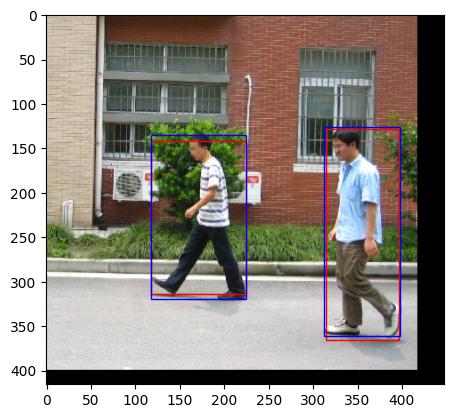

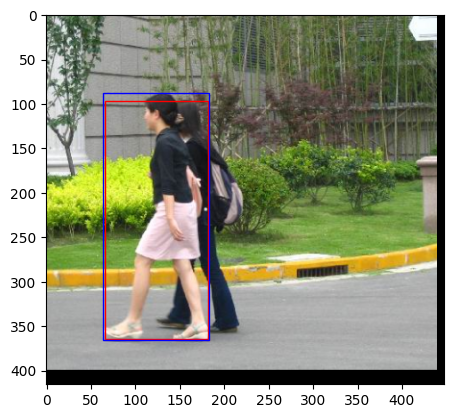

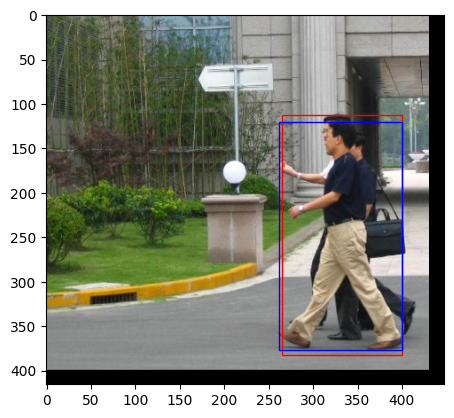

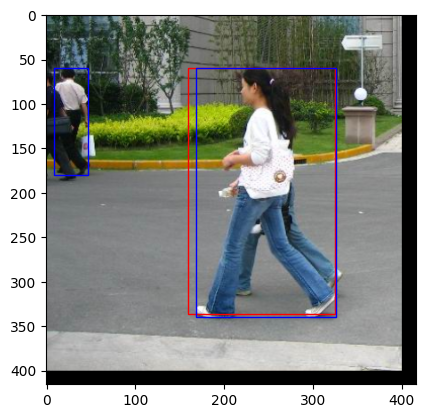

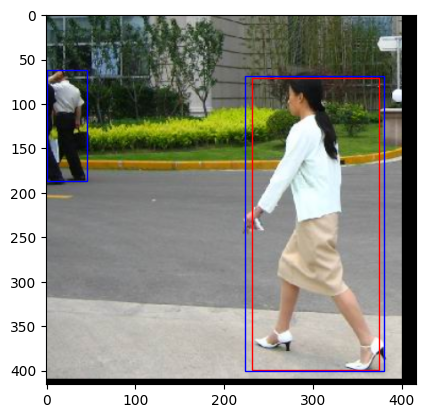

In [494]:
inference(yolo, dl)